In [11]:
from typing import Dict, Union, Tuple
import pandas as pd
import numpy as np
import scipy.stats as st
from networkx.generators import time_series
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

import seaborn as sns
import matplotlib.pyplot as plt

from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData
from src.data.data_utility import get_sliding_windows_from_sequence
from src.utils.training_class import TimeSeriesModelTrainer

In [4]:
# Load the data
print("Loading data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

print(f"Loaded {len(train_series)} training series and {len(test_series)} test series")
print(f"Class distribution - Positive: {sum(ts.has_break for ts in train_series.values())}, "
      f"Negative: {sum(not ts.has_break for ts in train_series.values())}")

Loading data...


INFO:src.data.dataLoader:Data loaded successfully from local files


Loaded 10001 training series and 101 test series
Class distribution - Positive: 2909, Negative: 7092


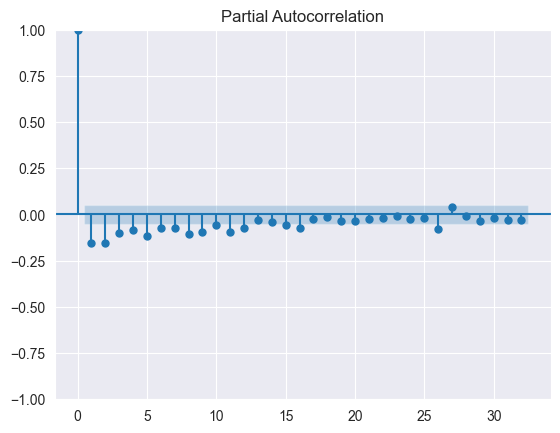

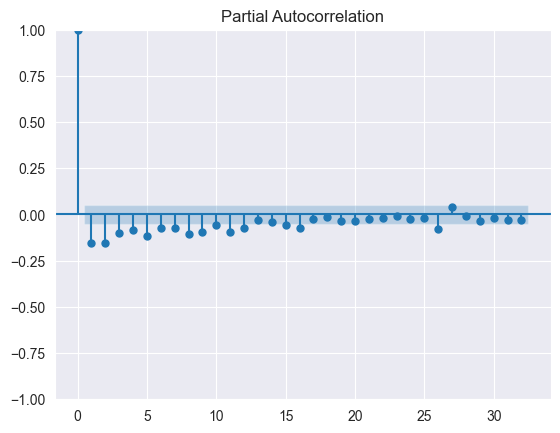

In [5]:
ex = train_series[0].period_0_values
p_corr, conf_int = pacf(ex, alpha=0.95)
plot_pacf(ex)

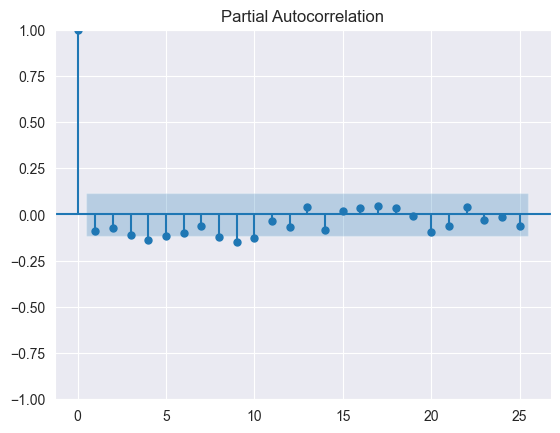

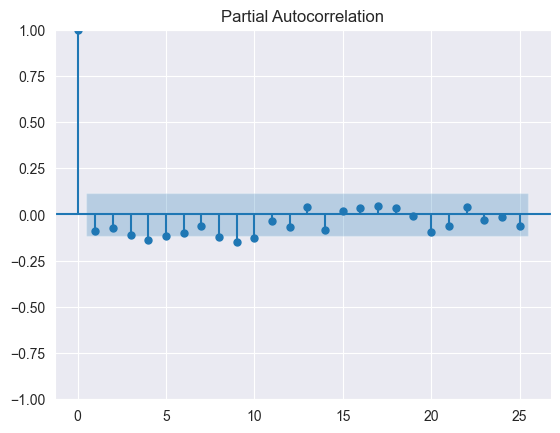

In [6]:
ex = train_series[0].period_1_values
p_corr, conf_int = pacf(ex, alpha=0.95)
plot_pacf(ex)

In [8]:
ex = train_series[0].values

In [9]:
vals, conf = pacf(ex, alpha=0.05)
sig = 0
for lag in range(1, len(vals)):
    lo, hi = conf[lag]
    # CI does not contain zero?
    if hi < 0 or lo > 0:
        sig += 1

In [10]:
sig

16

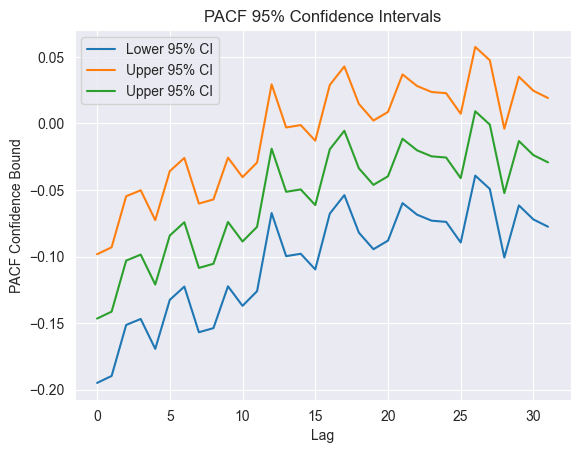

In [12]:


# conf.shape == (nlags+1, 2)
n = conf.shape[0] - 1
lags = np.arange(n)

plt.figure()
sns.lineplot(x=lags, y=conf[1:, 0], label='Lower 95% CI')
sns.lineplot(x=lags, y=conf[1:, 1], label='Upper 95% CI')
sns.lineplot(x=lags, y=vals[1:], label='Upper 95% CI')
plt.xlabel('Lag')
plt.ylabel('PACF Confidence Bound')
plt.title('PACF 95% Confidence Intervals')
plt.legend()
plt.show()

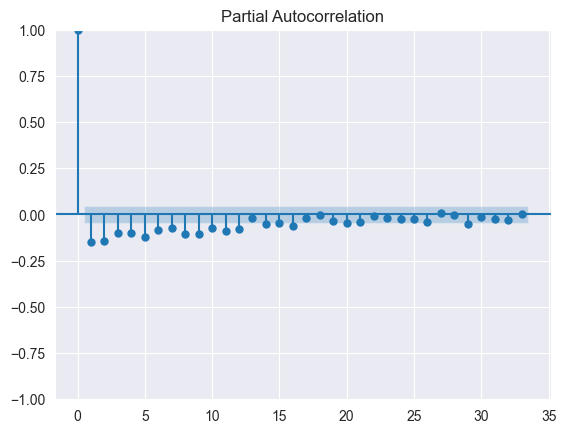

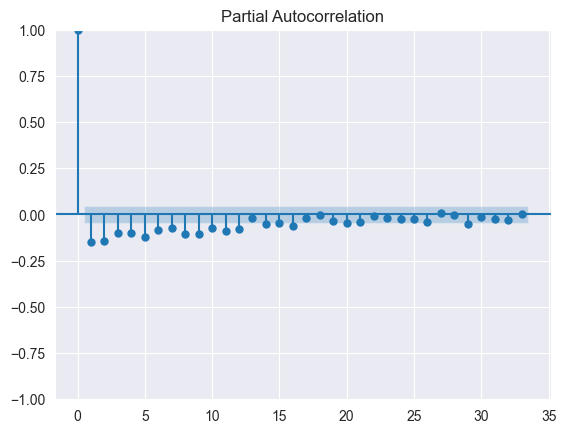

In [13]:
plot_pacf(ex)

In [14]:
f = train_series[0]
lags=10

In [15]:
def _build_lagged_matrix(series: np.ndarray, lags) -> Tuple[np.ndarray, np.ndarray]:
    """Build lagged design matrix X and vector y. Returns (None, None) if insufficient length."""
    N = len(series)

    y = series[lags:]
    X = np.ones((N - lags, lags + 1), dtype=float)

    for j in range(1, lags + 1):
        X[:, j] = series[lags - j: N - j]

    return X, y

In [16]:
def _ols_fit(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    """Fit OLS: returns beta, residuals, rss."""
    XT_X = X.T.dot(X)
    try:
        beta = np.linalg.solve(XT_X, X.T.dot(y))
    except np.linalg.LinAlgError:
        beta = np.linalg.pinv(XT_X).dot(X.T.dot(y))

    resid = y - X.dot(beta)
    rss = float(resid.dot(resid))

    return beta, resid, rss

In [34]:
def cumsum(f):
    feats = {}
    series_full = f.values
    
    # Build lagged matrices
    X_full, y_full = _build_lagged_matrix(series_full, lags=lags)
    X_pre, y_pre = _build_lagged_matrix(series_full, lags=lags)
    X_post, y_post = _build_lagged_matrix(series_full, lags=lags)
    
    # Sample sizes
    n_pre = 0 if y_pre is None else len(y_pre)
    n_post = 0 if y_post is None else len(y_post)
    n_full = 0 if y_full is None else len(y_full)
    
    m = lags + 1
    
    # Fit full OLS
    beta_full, resid_full, rss_full = _ols_fit(X_full, y_full)
    
    df_resid = n_full - m
    sigma_hat = np.sqrt(rss_full / df_resid)
    
    # Effective break index in residuals
    K = len(f.period_0_values)
    k_eff = K - lags
    u = k_eff / n_full
    
    # CUSUM statistic
    resid_pre = resid_full[:k_eff]
    S = float(np.sum(resid_pre))
    
    denom = sigma_hat * np.sqrt(n_full * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))
    feats["T_cumsum"] = T_cusum
    feats["p_cumsum"] = p_cusum
    
    # CUSUMSQ statistic
    sumsq_pre = float(np.sum(resid_pre**2))
    C = sumsq_pre / rss_full
    var_C = 2 * u * (1 - u) / (n_full + 2)
    
    Z_cusumsq = (C - u) / np.sqrt(var_C)
    p_cusumsq = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))
    feats['cusumsq_stat'] = float(Z_cusumsq)
    feats['cusumsq_pvalue'] = float(p_cusumsq)
    return feats

In [21]:
from tqdm import tqdm

feature_list = []
labels = []
series_ids = []
for series_id, ts_obj in tqdm(train_series.items()):
    feats = cumsum(ts_obj)
    
    feature_list.append(feats)
    series_ids.append(series_id)
    labels.append(ts_obj.has_break)

feature_df = pd.DataFrame(feature_list, index=series_ids)
label_series = pd.Series(labels, index=series_ids, name='has_break')
    

100%|██████████| 10001/10001 [00:02<00:00, 3433.22it/s]


In [44]:
def feat_ex_1(ts_obj: TimeSeriesData):
    feats = cumsum(ts_obj)
    feats = pd.DataFrame([feats])
    return feats

In [45]:
trainClass = TimeSeriesModelTrainer(feat_ex_1)

<Axes: xlabel='p_cumsum', ylabel='Count'>

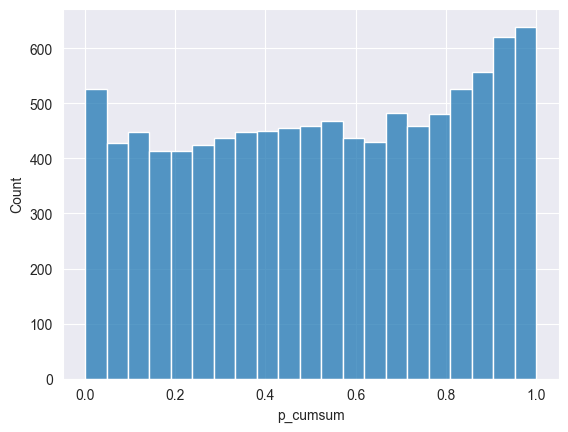

In [22]:
import seaborn as sns
sns.histplot(feature_df.p_cumsum)

<Axes: xlabel='has_break', ylabel='p_cumsum'>

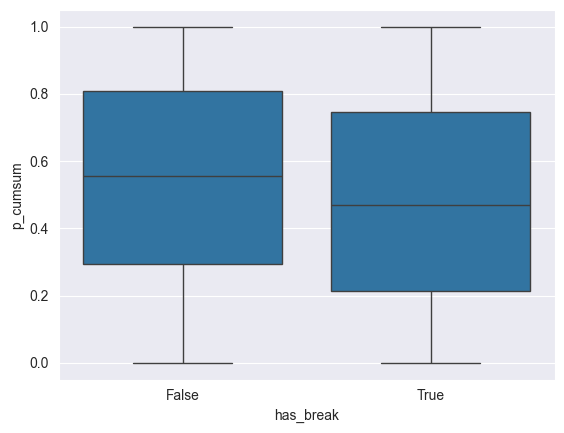

In [23]:
sns.boxplot(y=feature_df.p_cumsum, x=label_series)

<Axes: xlabel='has_break', ylabel='T_cumsum'>

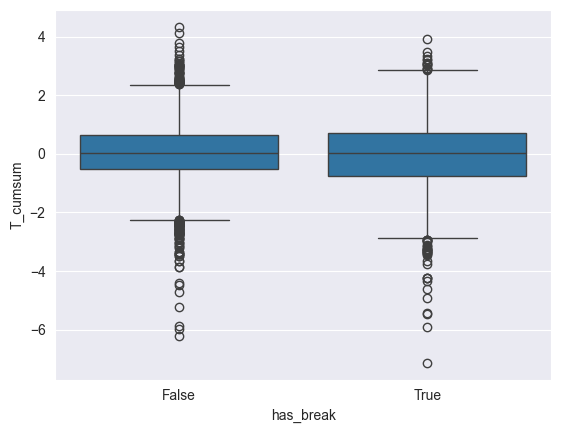

In [24]:
sns.boxplot(y=feature_df.T_cumsum, x=label_series)

<Axes: xlabel='has_break', ylabel='cusumsq_stat'>

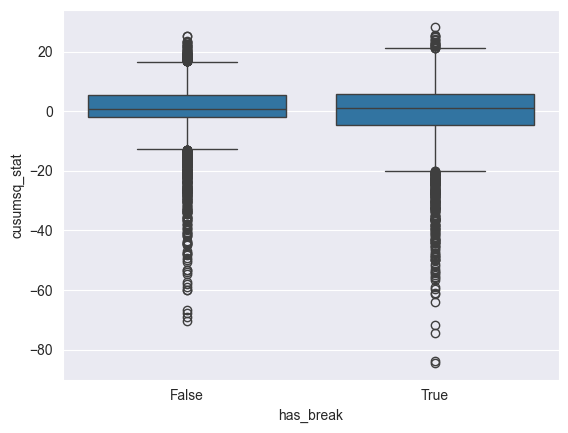

In [25]:
sns.boxplot(y=feature_df.cusumsq_stat, x=label_series)

<Axes: xlabel='has_break', ylabel='cusumsq_pvalue'>

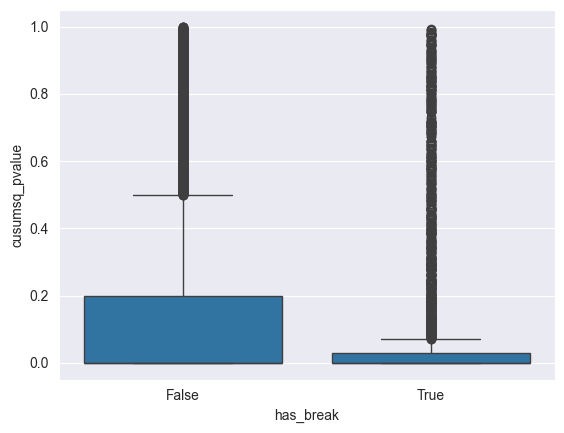

In [26]:
sns.boxplot(y=feature_df.cusumsq_pvalue, x=label_series)

In [27]:
import statsmodels.api as sm

In [28]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(feature_df, label_series)

LogisticRegressionCV()

In [29]:
md = cross_validate(model, feature_df, label_series, cv=5, scoring='roc_auc')

In [30]:
md["test_score"].mean()

np.float64(0.5607428615482876)

In [46]:
trainClass.train_and_evaluate()

INFO:src.utils.training_class:Loading data automatically using StructuralBreakDataLoader...
INFO:src.data.dataLoader:Data loaded successfully from local files
INFO:src.utils.training_class:Loaded 10001 training time series automatically
INFO:src.utils.training_class:Extracting features from 10001 time series...
Extracting features: 100%|██████████| 10001/10001 [00:03<00:00, 2648.01it/s]
INFO:src.utils.training_class:Successfully extracted 4 features from 10001 series
INFO:src.utils.training_class:Dataset shape: (10001, 4)
INFO:src.utils.training_class:Class distribution: {False: 7092, True: 2909}
INFO:src.utils.training_class:Performing 10-fold cross-validation...
INFO:src.utils.training_class:Training final model on full dataset...
INFO:src.utils.training_class:Training completed successfully!


{'cv_val_mean': 0.6035638939067891,
 'cv_val_std': 0.013198570100456846,
 'cv_train_mean': 0.7460855647100713,
 'cv_train_std': 0.005908806310583774,
 'val_scores': array([0.61182905, 0.62298932, 0.59358324, 0.58294437, 0.60507757,
        0.62132911, 0.59624417, 0.61140273, 0.59181413, 0.59842525]),
 'train_scores': array([0.74306748, 0.75070505, 0.74537895, 0.75008518, 0.74890349,
        0.73770132, 0.73911425, 0.75061081, 0.75523096, 0.74005816]),
 'y_true': array([False, False,  True, ..., False, False,  True], shape=(10001,)),
 'y_pred_proba': array([0.10256897, 0.30059773, 0.5097021 , ..., 0.15869154, 0.22879404,
        0.281566  ], shape=(10001,), dtype=float32),
 'feature_count': 4,
 'sample_count': 10001,
 'class_distribution': {False: 7092, True: 2909}}

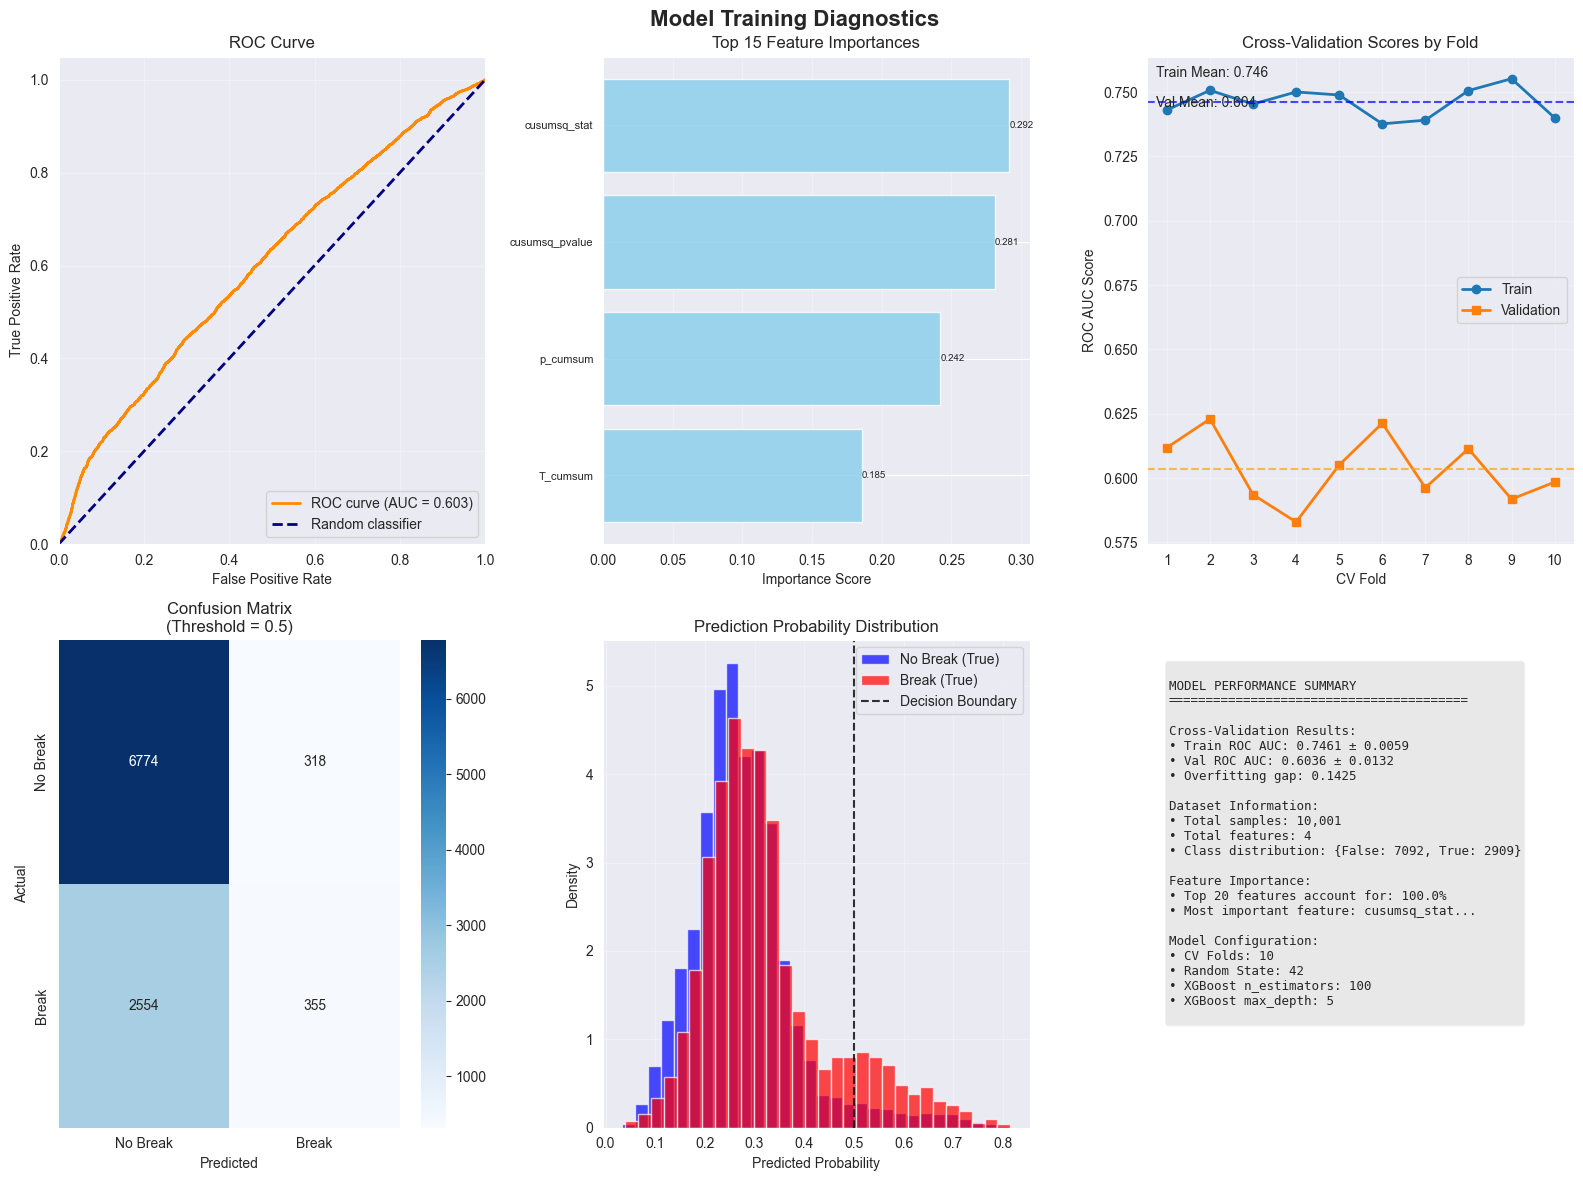

In [47]:
trainClass.plot_diagnostics()

In [77]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegressionCV
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats as st

best_score = -np.inf
best_lag = None
scores_per_lag = {}

for lag in range(1, 16):  # Try lags from 1 to 15
    lags = lag 
    
    feature_list = []
    labels = []
    series_ids = []
    
    for series_id, ts_obj in train_series.items():
        feats = cumsum(ts_obj)
        feature_list.append(feats)
        series_ids.append(series_id)
        labels.append(ts_obj.has_break)

    feature_df = pd.DataFrame(feature_list, index=series_ids)
    label_series = pd.Series(labels, index=series_ids, name='has_break')
    
    # Drop any rows with NaN (can happen for very short time series)
    X = feature_df.dropna()
    y = label_series.loc[X.index]
    
    model = LogisticRegressionCV(max_iter=1000)
    cv_result = cross_validate(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    mean_score = cv_result["test_score"].mean()
    
    scores_per_lag[lag] = mean_score
    if mean_score > best_score:
        best_score = mean_score
        best_lag = lag
    
    print(f"Lag {lag:2d} — AUC: {mean_score:.4f}")

print("\n=== Best Lag ===")
print(f"Lag {best_lag} with AUC {best_score:.4f}")


Lag  1 — AUC: 0.5666
Lag  2 — AUC: 0.5794
Lag  3 — AUC: 0.5794
Lag  4 — AUC: 0.5685
Lag  5 — AUC: 0.5801
Lag  6 — AUC: 0.5678
Lag  7 — AUC: 0.5599
Lag  8 — AUC: 0.5602
Lag  9 — AUC: 0.5604
Lag 10 — AUC: 0.5607
Lag 11 — AUC: 0.5605
Lag 12 — AUC: 0.5692
Lag 13 — AUC: 0.5696
Lag 14 — AUC: 0.5701
Lag 15 — AUC: 0.5702

=== Best Lag ===
Lag 5 with AUC 0.5801


In [206]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
import scipy.stats as st

# — assume train_series is your dict of time‐series objects —

def count_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05) -> int:
    """Return number of lags whose PACF is outside the (1-alpha) conf. interval."""
    vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
    sig = 0
    # skip lag=0
    for lag in range(1, len(vals)):
        lo, hi = conf[lag]
        if hi < 0 or lo > 0:
            sig += 1
    return sig

def cumsum_with_custom_lag(ts_obj, lags: int):
    """
    Compute CUSUM and CUSUMSQ using `lags` for the lagged regression.
    Returns dict of features.
    """
    series_full = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])
    K = len(ts_obj.period_0_values)
    
    # build X,y with `lags`
    N = len(series_full)
    if N <= lags:
        # too short
        return dict.fromkeys(
            ["T_cumsum","p_cumsum","cusumsq_stat","cusumsq_pvalue"], 
            np.nan
        )
    
    # y = series_full[lags:], X[:,j] = lagged values + intercept
    y = series_full[lags:]
    X = np.ones((N - lags, lags + 1))
    for j in range(1, lags + 1):
        X[:, j] = series_full[lags - j : N - j]

    # OLS
    XT_X = X.T.dot(X)
    beta = np.linalg.solve(XT_X, X.T.dot(y))
    resid = y - X.dot(beta)
    rss_full = float(resid.dot(resid))

    # residual‐based CUSUM
    df_resid = len(y) - (lags + 1)
    sigma_hat = np.sqrt(rss_full / df_resid)

    k_eff = K - lags
    u = k_eff / len(y)
    resid_pre = resid[:k_eff]
    
    S = resid_pre.sum()
    denom = sigma_hat * np.sqrt(len(y) * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))

    # CUSUMSQ
    sumsq_pre = (resid_pre**2).sum()
    C = sumsq_pre / rss_full
    var_C = 2 * u * (1 - u) / (len(y) + 2)
    Z_cusumsq = (C - u) / np.sqrt(var_C)
    p_cusumsq = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))

    return {
        "n_sig_pacf_lags": lags,
        "T_cumsum":        T_cusum,
        "p_cumsum":        p_cusum,
        "cusumsq_stat":    Z_cusumsq,
        "cusumsq_pvalue":  p_cusumsq
    }

# — now loop over all series, first count PACF‐sig lags, then compute CUSUM with that lag —
feature_rows = []
labels       = []
idxs         = []

for sid, ts_obj in train_series.items():
    full_series = np.concatenate([ts_obj.period_0_values,
                                 ts_obj.period_1_values])
    # 1) count PACF‐significant lags up to some max (e.g. 15)
    best_lag = count_sig_pacf_lags(full_series, max_lag=30, alpha=0.05)
    
    # 2) compute CUSUM features using that lag
    feats = cumsum_with_custom_lag(ts_obj, lags=best_lag)
    
    feature_rows.append(feats)
    labels.append(ts_obj.has_break)
    idxs.append(sid)

# assemble into DataFrame
feature_df = pd.DataFrame(feature_rows, index=idxs)
label_s    = pd.Series(labels, index=idxs, name="has_break")

# quick check
print(feature_df.head())


   n_sig_pacf_lags  T_cumsum  p_cumsum  cusumsq_stat  cusumsq_pvalue
0               16 -0.117478  0.906482      0.445677        0.655831
1                4  1.449410  0.147223      3.852740        0.000117
2                2 -1.795879  0.072514     -9.470579        0.000000
3                0  0.141647  0.887359     -3.355278        0.000793
4                4 -0.153134  0.878293     -0.285717        0.775095


<Axes: xlabel='n_sig_pacf_lags', ylabel='Count'>

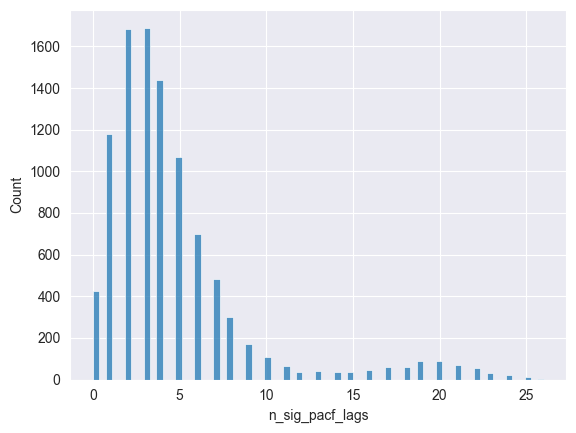

In [207]:
sns.histplot(feature_df.n_sig_pacf_lags)

In [121]:
model = LogisticRegressionCV()
model.fit(feature_df, label_series)
md = cross_validate(model, feature_df, label_series, cv=5, scoring='roc_auc')
md["test_score"].mean()

np.float64(0.587167306799557)

In [144]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 1) Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 2) Cross-validate with ROC AUC
cv_results = cross_validate(
    xgb_model,
    feature_df,
    label_series,
    cv=5,
    scoring='roc_auc',
    return_train_score=False,
    n_jobs=-1
)

# 3) Print the mean test AUC
mean_auc = cv_results["test_score"].mean()
print("AUC per fold:", cv_results["test_score"])
print(f"Mean AUC: {mean_auc:.4f}")


AUC per fold: [0.6198608  0.63702894 0.63709474 0.62076566 0.62113099]
Mean AUC: 0.6272


In [163]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
import scipy.stats as st

def get_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05):
    """
    Returns the sorted list of lags (1…max_lag) whose PACF 95% CI excludes zero.
    """
    vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
    sig_lags = [
        lag for lag in range(1, len(vals))
        if (conf[lag][1] < 0) or (conf[lag][0] > 0)
    ]
    return sig_lags

def cumsum_with_specific_lags(ts_obj, lags: list):
    """
    Compute CUSUM/CUSUMSQ using exactly the provided list of lags.
    Returns dict of features plus the lags used.
    """
    series_full = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])
    K = len(ts_obj.period_0_values)
    N = len(series_full)
    
    # if no lags or too short, bail
    if not lags or N <= max(lags):
        return {"used_lags": lags, **{k: np.nan for k in ["T_cumsum","p_cumsum","cusumsq_stat","cusumsq_pvalue"]}}
    
    # Build X: intercept + each specified lag
    y = series_full[max(lags):]
    X = np.ones((len(y), len(lags) + 1))
    for i, lag in enumerate(lags, start=1):
        X[:, i] = series_full[max(lags) - lag : N - lag]
    
    # OLS fit
    XT_X = X.T @ X
    beta = np.linalg.solve(XT_X, X.T @ y)
    resid = y - X @ beta
    rss  = float(resid @ resid)
    
    # CUSUM
    df_resid   = len(y) - len(beta)
    sigma_hat  = np.sqrt(rss / df_resid)
    k_eff      = K - max(lags)
    u          = k_eff / len(y)
    resid_pre  = resid[:k_eff]
    
    S = resid_pre.sum()
    denom = sigma_hat * np.sqrt(len(y) * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))
    
    # CUSUMSQ
    sumsq_pre  = (resid_pre**2).sum()
    C          = sumsq_pre / rss
    var_C      = 2 * u * (1 - u) / (len(y) + 2)
    Z_cusumsq  = (C - u) / np.sqrt(var_C)
    p_cusumsq  = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))
    
    return {
        "used_lags":       lags,
        "T_cumsum":        T_cusum,
        "p_cumsum":        p_cusum,
        "cusumsq_stat":    Z_cusumsq,
        "cusumsq_pvalue":  p_cusumsq
    }

# — full pipeline —
feature_rows = []
labels       = []

for sid, ts_obj in train_series.items():
    full_series = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])

    # 1) find exactly which lags are significant
    sig_lags = get_sig_pacf_lags(full_series, max_lag=15, alpha=0.05)

    # 2) compute CUSUM features using *only* those lags
    feats = cumsum_with_specific_lags(ts_obj, sig_lags)

    feature_rows.append(feats)
    labels.append(ts_obj.has_break)

# assemble
feature_df = pd.DataFrame(feature_rows, index=train_series.keys())
label_s    = pd.Series(labels, index=train_series.keys(), name="has_break")

print(feature_df.head())

                                         used_lags  T_cumsum  p_cumsum  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15] -0.136953  0.891068   
1                                   [2, 9, 11, 14]  1.491335  0.135873   
2                                              [1] -1.768624  0.076957   
3                                               []       NaN       NaN   
4                                              [1] -0.176228  0.860115   

   cusumsq_stat  cusumsq_pvalue  
0      0.596105        0.551105  
1      4.001351        0.000063  
2     -9.504726        0.000000  
3           NaN             NaN  
4     -0.160465        0.872515  


In [164]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 1) Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 2) Cross-validate with ROC AUC
cv_results = cross_validate(
    xgb_model,
    feature_df.drop("used_lags", axis=1),
    label_series,
    cv=5,
    scoring='roc_auc',
    return_train_score=False,
    n_jobs=-1
)

# 3) Print the mean test AUC
mean_auc = cv_results["test_score"].mean()
print("AUC per fold:", cv_results["test_score"])
print(f"Mean AUC: {mean_auc:.4f}")


AUC per fold: [0.60884801 0.61112769 0.58864428 0.60972329 0.60547805]
Mean AUC: 0.6048


In [165]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
import scipy.stats as st

def get_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05):
    """
    Returns the sorted list of lags (1…max_lag) whose PACF 95% CI excludes zero.
    If none are significant, returns [1].
    """
    vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
    sig_lags = [
        lag for lag in range(1, len(vals))
        if (conf[lag][1] < 0) or (conf[lag][0] > 0)
    ]
    return sig_lags if sig_lags else [1]

def cumsum_with_specific_lags(ts_obj, lags: list):
    """
    Compute CUSUM/CUSUMSQ using exactly the provided list of lags.
    Returns dict of features plus the lags used.
    """
    series_full = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])
    K = len(ts_obj.period_0_values)
    N = len(series_full)
    max_lag = max(lags)
    
    # if too short, bail with NaNs
    if N <= max_lag:
        return {"used_lags": lags,
                **{k: np.nan for k in ["T_cumsum","p_cumsum","cusumsq_stat","cusumsq_pvalue"]}}
    
    # Build y and design matrix X (intercept + each specified lag)
    y = series_full[max_lag:]
    X = np.ones((len(y), len(lags) + 1))
    for i, lag in enumerate(lags, start=1):
        X[:, i] = series_full[max_lag - lag : N - lag]
    
    # OLS fit
    XT_X = X.T @ X
    beta = np.linalg.solve(XT_X, X.T @ y)
    resid = y - X @ beta
    rss  = float(resid @ resid)
    
    # CUSUM
    df_resid   = len(y) - len(beta)
    sigma_hat  = np.sqrt(rss / df_resid)
    k_eff      = K - max_lag
    u          = k_eff / len(y)
    resid_pre  = resid[:k_eff]
    
    S = resid_pre.sum()
    denom = sigma_hat * np.sqrt(len(y) * u * (1 - u))
    T_cusum = S / denom
    p_cusum = 2 * (1 - st.norm.cdf(abs(T_cusum)))
    
    # CUSUMSQ
    sumsq_pre  = (resid_pre**2).sum()
    C          = sumsq_pre / rss
    var_C      = 2 * u * (1 - u) / (len(y) + 2)
    Z_cusumsq  = (C - u) / np.sqrt(var_C)
    p_cusumsq  = 2 * (1 - st.norm.cdf(abs(Z_cusumsq)))
    
    return {
        "used_lags":       lags,
        "T_cumsum":        T_cusum,
        "p_cumsum":        p_cusum,
        "cusumsq_stat":    Z_cusumsq,
        "cusumsq_pvalue":  p_cusumsq
    }

# — full pipeline to build features DataFrame —
feature_rows = []
labels       = []

for sid, ts_obj in train_series.items():
    full_series = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])

    # 1) find exactly which lags are significant (or [1] if none)
    sig_lags = get_sig_pacf_lags(full_series, max_lag=15, alpha=0.05)

    # 2) compute CUSUM features using those exact lags
    feats = cumsum_with_specific_lags(ts_obj, sig_lags)

    feature_rows.append(feats)
    labels.append(ts_obj.has_break)

# assemble into DataFrame
feature_df = pd.DataFrame(feature_rows, index=train_series.keys())
label_s    = pd.Series(labels,           index=train_series.keys(), name="has_break")

print(feature_df.head())


                                         used_lags  T_cumsum  p_cumsum  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15] -0.136953  0.891068   
1                                   [2, 9, 11, 14]  1.491335  0.135873   
2                                              [1] -1.768624  0.076957   
3                                              [1]  0.173200  0.862494   
4                                              [1] -0.176228  0.860115   

   cusumsq_stat  cusumsq_pvalue  
0      0.596105        0.551105  
1      4.001351        0.000063  
2     -9.504726        0.000000  
3     -3.427479        0.000609  
4     -0.160465        0.872515  


In [169]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 1) Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 2) Cross-validate with ROC AUC
cv_results = cross_validate(
    xgb_model,
    feature_df.drop("used_lags", axis=1),
    label_series,
    cv=5,
    scoring='roc_auc',
    return_train_score=False,
    n_jobs=-1
)

xgb_model.fit(feature_df.drop("used_lags", axis=1), label_series)

# 3) Print the mean test AUC
mean_auc = cv_results["test_score"].mean()
print("AUC per fold:", cv_results["test_score"])
print(f"Mean AUC: {mean_auc:.4f}")


AUC per fold: [0.61323133 0.62634228 0.6102928  0.61866939 0.61318335]
Mean AUC: 0.6163


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:41:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [170]:
xgb_model.feature_importances_

array([0.0825171 , 0.1503906 , 0.36784303, 0.3992493 ], dtype=float32)

In [171]:
xgb_model.feature_names_in_

array(['T_cumsum', 'p_cumsum', 'cusumsq_stat', 'cusumsq_pvalue'],
      dtype='<U14')

In [186]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
import scipy.stats as st

def get_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05):
    vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
    sig_lags = [
        lag for lag in range(1, len(vals))
        if (conf[lag][1] < 0) or (conf[lag][0] > 0)
    ]
    return sig_lags  # may be empty

def compute_cusum(ts_obj, lags: list):
    series_full = np.concatenate([ts_obj.period_0_values, ts_obj.period_1_values])
    K = len(ts_obj.period_0_values)
    if not lags:
        # mark as missing
        return {"used_lags": [], "T_cumsum": np.nan, "p_cumsum": np.nan,
                "cusumsq_stat": np.nan, "cusumsq_pvalue": np.nan}
    
    max_lag = max(lags)
    N = len(series_full)
    if N <= max_lag:
        # too short
        return {"used_lags": lags, "T_cumsum": np.nan, "p_cumsum": np.nan,
                "cusumsq_stat": np.nan, "cusumsq_pvalue": np.nan}

    # Build lagged regression
    y = series_full[max_lag:]
    X = np.ones((len(y), len(lags) + 1))
    for i, lag in enumerate(lags, start=1):
        X[:, i] = series_full[max_lag - lag : N - lag]

    # OLS
    beta = np.linalg.solve(X.T @ X, X.T @ y)
    resid = y - X @ beta
    rss = float(resid @ resid)

    # CUSUM
    df_resid  = len(y) - len(beta)
    sigma_hat = np.sqrt(rss / df_resid)
    k_eff     = K - max_lag
    u         = k_eff / len(y)
    resid_pre = resid[:k_eff]

    S        = resid_pre.sum()
    denom    = sigma_hat * np.sqrt(len(y) * u * (1 - u))
    T_cusum  = S / denom
    p_cusum  = 2 * (1 - st.norm.cdf(abs(T_cusum)))

    # CUSUMSQ
    sumsq_pre = (resid_pre**2).sum()
    C         = sumsq_pre / rss
    var_C     = 2 * u * (1 - u) / (len(y) + 2)
    Z_cs     = (C - u) / np.sqrt(var_C)
    p_cs     = 2 * (1 - st.norm.cdf(abs(Z_cs)))

    return {"used_lags": lags,
            "T_cumsum": T_cusum, "p_cumsum": p_cusum,
            "cusumsq_stat": Z_cs, "cusumsq_pvalue": p_cs}

# — Pass 1: extract everything, with NaNs for “no lags” —
rows = []
labels = []
for sid, ts in train_series.items():
    full = np.concatenate([ts.period_0_values, ts.period_1_values])
    sig_lags = get_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    feats = compute_cusum(ts, sig_lags)
    rows.append(feats)
    labels.append(ts.has_break)

df = pd.DataFrame(rows, index=train_series.keys())
label_s = pd.Series(labels, index=train_series.keys(), name="has_break")

# — Pass 2: impute NaNs with column means —
stats_cols = ["T_cumsum", "p_cumsum", "cusumsq_stat", "cusumsq_pvalue"]
means = df[stats_cols].mean()

df[stats_cols] = df[stats_cols].fillna(means)

print("Imputed with means:", means.to_dict())
print(df.head())


Imputed with means: {'T_cumsum': 0.0031167091203339312, 'p_cumsum': 0.5308357137919146, 'cusumsq_stat': 0.2646926634642123, 'cusumsq_pvalue': 0.13241559292826485}
                                         used_lags  T_cumsum  p_cumsum  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15] -0.136953  0.891068   
1                                   [2, 9, 11, 14]  1.491335  0.135873   
2                                              [1] -1.768624  0.076957   
3                                               []  0.003117  0.530836   
4                                              [1] -0.176228  0.860115   

   cusumsq_stat  cusumsq_pvalue  
0      0.596105        0.551105  
1      4.001351        0.000063  
2     -9.504726        0.000000  
3      0.264693        0.132416  
4     -0.160465        0.872515  


In [187]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# 1) Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# 2) Cross-validate with ROC AUC
cv_results = cross_validate(
    xgb_model,
    feature_df.drop("used_lags", axis=1),
    label_series,
    cv=5,
    scoring='roc_auc',
    return_train_score=False,
    n_jobs=-1
)

xgb_model.fit(feature_df.drop("used_lags", axis=1), label_series)

# 3) Print the mean test AUC
mean_auc = cv_results["test_score"].mean()
print("AUC per fold:", cv_results["test_score"])
print(f"Mean AUC: {mean_auc:.4f}")


AUC per fold: [0.61323133 0.62634228 0.6102928  0.61866939 0.61318335]
Mean AUC: 0.6163


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:48:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


       mean_auc
alpha          
0.04   0.628891
0.10   0.628704
0.08   0.627670
0.07   0.627318
0.14   0.627236
0.05   0.627176
0.12   0.627033
0.11   0.626569
0.06   0.626498
0.03   0.625990
0.15   0.625800
0.09   0.625370
0.13   0.625021
0.01   0.624986
0.02   0.621144


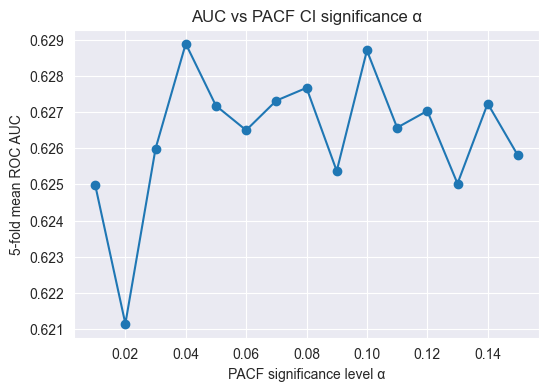

In [189]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

# build the label vector once
label_series = pd.Series(
    [ts.has_break for ts in train_series.values()],
    index=train_series.keys(),
    name="has_break"
)

results = []
alphas = np.arange(0.01, 0.16, 0.01)

for alpha in alphas:
    # 1) extract features under this alpha
    feats = []
    for ts in train_series.values():
        full = np.concatenate([ts.period_0_values, ts.period_1_values])
        best_lag = count_sig_pacf_lags(full, max_lag=15, alpha=alpha)
        feats.append(cumsum_with_custom_lag(ts, lags=best_lag))
    feature_df = pd.DataFrame(feats, index=train_series.keys())
    
    # 2) CV with XGBoost
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.03,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
    cv = cross_validate(
        model,
        feature_df,
        label_series,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    results.append({
        "alpha": alpha,
        "mean_auc": cv["test_score"].mean()
    })

# 3) summarize
res_df = pd.DataFrame(results).set_index("alpha")
print(res_df.sort_values("mean_auc", ascending=False))

# 4) plot
plt.figure(figsize=(6,4))
plt.plot(res_df.index, res_df["mean_auc"], marker="o")
plt.xlabel("PACF significance level α")
plt.ylabel("5-fold mean ROC AUC")
plt.title("AUC vs PACF CI significance α")
plt.grid(True)
plt.show()
